# https://www.kaggle.com/code/peterholderrieth/getting-started-data-loading

In [1]:
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import os, time
import urllib.request 

from biopandas.pdb import PandasPdb
import blosum as bl


from sklearn.linear_model import LinearRegression
try:
    import Levenshtein
    from Levenshtein import distance as levenshtein_distance
except Exception as e:
    print(e)
    !pip install Levenshtein
    import Levenshtein
    from Levenshtein import distance as levenshtein_distance
    
try:
    import tables
except Exception as e:
    !pip install tables
    import tables
    

In [2]:
DATA_DIR = "../../../open-problems-multimodal"
from os.path import isdir, isfile, join


In [3]:
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [4]:
# Check meta data
meta_data = pd.read_csv(FP_CELL_METADATA)
print(meta_data.head())
print(meta_data.dtypes)


        cell_id  day  donor cell_type technology
0  c2150f55becb    2  27678       HSC    citeseq
1  65b7edf8a4da    2  27678       HSC    citeseq
2  c1b26cb1057b    2  27678      EryP    citeseq
3  917168fa6f83    2  27678      NeuP    citeseq
4  2b29feeca86d    2  27678      EryP    citeseq
cell_id       object
day            int64
donor          int64
cell_type     object
technology    object
dtype: object


In [5]:
print(meta_data.technology.unique())

['citeseq' 'multiome']


Split cells by technology

In [6]:
df_cell_cite = meta_data[meta_data.technology=="citeseq"]
df_cell_multi = meta_data[meta_data.technology=="multiome"]

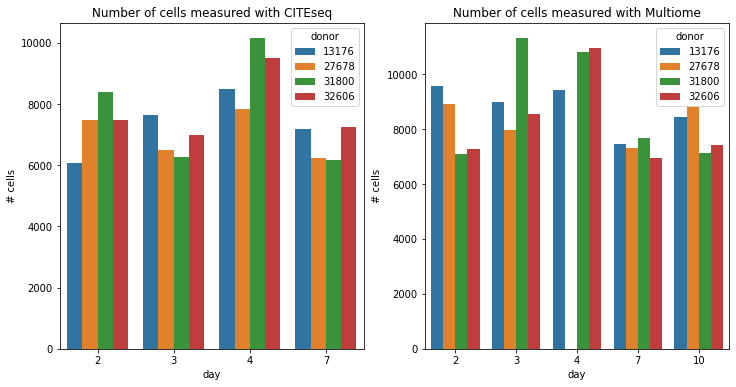

In [7]:
import seaborn as sns

fig, axs = plt.subplots(1,2,figsize=(12,6))
df_cite_cell_dist = df_cell_cite.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_cite_cell_dist, x="day",hue="donor",y="# cells", ax=axs[0])
axs[0].set_title("Number of cells measured with CITEseq")

df_multi_cell_dist = df_cell_multi.set_index("cell_id")[["day","donor"]].value_counts().to_frame()\
                .sort_values("day").reset_index()\
                .rename(columns={0:"# cells"})
sns.barplot(data=df_multi_cell_dist, x="day",hue="donor",y="# cells", ax=axs[1])
axs[1].set_title("Number of cells measured with Multiome")
plt.show()

Inputs: For the RNA counts, each row corresponds to a cell and each column to a gene. The column format for a gene is given by {EnsemblID}_{GeneName} where EnsemblID refers to the Ensembl Gene ID and GeneName to the gene name.

In [8]:
START = 0
STOP = START+1000

df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS,start=START,stop=STOP)
df_cite_test_x = pd.read_hdf(FP_CITE_TEST_INPUTS,start=START,stop=STOP)
df_cite_train_x.head()

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


Targets: For the surface protein levels, each row corresponds to a cell and each column to a protein:

In [9]:
df_cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
df_cite_train_y.head()

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445
